# Tuning logistic regression
I decided to see if I could get better performance with LR than a tuned Adaboost by tuning the positive threshold. 

This attempt turned out to be successful

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.feature_selection import SelectKBest,  mutual_info_classif
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold

In [3]:
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score
from imblearn.over_sampling import RandomOverSampler

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [5]:
import matplotlib.pyplot as plt

## Repeating the same steps as before to prepare the data

The test data is being increased to 30% from 20% because the model was underfitting at 20%

In [6]:
data_1 = pd.read_csv('data/data_numeric.csv')
data_2 = pd.read_csv('data/data_categorical.csv')
data_2 = data_2.drop(columns='class')
credit = data_1.merge(data_2, how='inner', left_index=True, right_index=True)

y = credit['class']
x = credit.drop(columns='class')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1, stratify=y)

In [7]:
x_train_stand, x_test_stand = x_train.copy(), x_test.copy()

# noralised x data
norm = MinMaxScaler().fit(x_train)
x_train_norm = norm.transform(x_train)
x_test_norm = norm.transform(x_test)

# oversample the xtrain and ytrain dataset to increase the minority class to 70% 
oversample = RandomOverSampler(sampling_strategy=0.7, random_state=1)
x_train_os, y_train_os = oversample.fit_resample(x_train, y_train)

oversample = RandomOverSampler(sampling_strategy=0.7, random_state=1)
x_train_norm_os, y_train_norm_os = oversample.fit_resample(x_train_norm, y_train)

print(y_train_os.value_counts())
print(y_test.value_counts())
metrics = [accuracy_score, recall_score, roc_auc_score]
metric_names = ['accuracy', 'recall', 'roc_auc']

0    490
1    343
Name: class, dtype: int64
0    210
1     90
Name: class, dtype: int64


## Determining the optimal number of features without overcomplicating the model

In [8]:
x_train_norm_os = pd.DataFrame(x_train_norm_os, columns=x_train.columns)
x_test_norm = pd.DataFrame(x_test_norm, columns=x_train.columns)
x_train_norm_os.head()

,checking_status,duration,credit_amount,savings_status,employment,installment_commitment,residence_since,property_magnitude,age,existing_credits,...,housing_own,housing_rent,other_payment_plans_bank,other_payment_plans_none,other_payment_plans_stores,foreign_worker_no,foreign_worker_yes,purpose_radio,purpose_tv,purpose_used
0,0.333333,0.125000,0.119089,1.000000,1.000000,0.000000,0.333333,1.000000,0.160714,0.000000,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.333333,0.410714,0.532070,1.000000,0.294118,0.333333,0.333333,0.666667,0.142857,0.333333,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.000000,0.285714,0.255026,0.033333,1.000000,0.000000,1.000000,0.333333,0.089286,0.333333,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.666667,1.000000,0.925777,0.233333,1.000000,0.666667,1.000000,0.000000,0.732143,0.333333,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.666667,0.785714,0.618036,0.033333,0.058824,0.000000,0.333333,0.666667,0.125000,0.000000,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [9]:
def area_under_curve(variables, test_x, test_y):
    X = x_train_norm_os[variables]
    Y = y_train_os
    c1 = LogisticRegression(random_state=1, warm_start=True, solver='saga')
    
    c1.fit(X, Y)
    predictions = c1.predict_proba(test_x[variables])[:,1]
    auc = roc_auc_score(test_y, predictions)
    return auc

def next_best(current_variables, candidate_variables):
    best_auc = -1
    best_variable = None
    for v in candidate_variables:
        auc_v = area_under_curve(current_variables + [v], x_train_norm_os, y_train_os)
        if auc_v >= best_auc:
            best_auc = auc_v
            best_variable = v
            
    return best_variable


In [10]:
# Store the train and test AUC
auc_values_train = []
auc_values_test = []

candidate_variables = list(x_train_norm_os.columns)
current_variables = []
number_iterations = len(candidate_variables)

for i in range(number_iterations):
    # find the next best model with the train data
    next_variable = next_best(current_variables, candidate_variables)
    current_variables.append(next_variable)
    candidate_variables.remove(next_variable)
    
    # Calculate the train and test AUC of the current of variables
    auc_train = area_under_curve(current_variables, x_train_norm_os, y_train_os)
    auc_test = area_under_curve(current_variables, x_test_norm, y_test)
    
    # Append the values to the lists
    auc_values_train.append(auc_train)
    auc_values_test.append(auc_test)

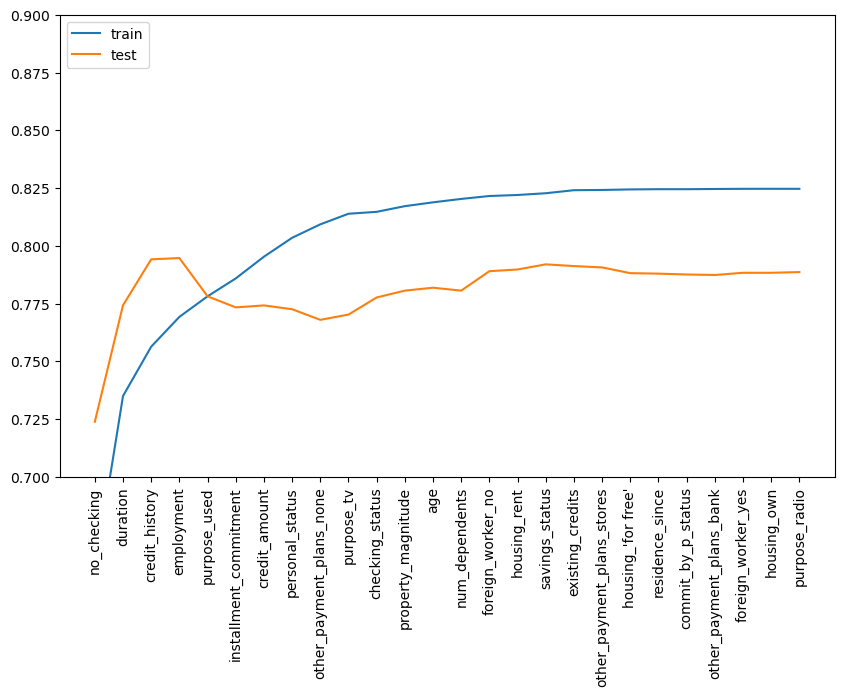

In [11]:
## Plotting AUC of train and test data by each additional feature
x = np.array(range(0,len(auc_values_train)))
plt.figure(figsize=(10, 6))
plt.xticks(x, current_variables, rotation=90)

y_train_plot = np.array(auc_values_train)
y_test_plot = np.array(auc_values_test)

plt.plot(x, y_train_plot, label='train')
plt.plot(x, y_test_plot, label='test')
plt.ylim((0.7, 0.9))

plt.legend(loc="upper left")
plt.show()

In [12]:
variables = current_variables[:17]
x_train_norm_os_model = x_train_norm_os[variables]
x_test_norm_model = x_test_norm[variables]

In [13]:
classif = LogisticRegression(random_state=1)
classif.fit(x_train_norm_os_model, y_train_os)
y_prob = classif.predict_proba(x_test_norm_model)[:,1]
y_hat = classif.predict(x_test_norm_model)

print(accuracy_score(y_test, y_hat))
print(recall_score(y_test, y_hat))
print(roc_auc_score(y_test, y_prob))

0.7166666666666667
0.6
0.791957671957672


In [14]:
np.random.seed(1)
scores_df = pd.DataFrame(index=metric_names)
results = []

# define classifier, feature selector, and cv method
classif = LogisticRegression(random_state=1, warm_start=True, solver='saga')
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=1)

# define the pipeline to evaluate
pipeline = Pipeline(steps=[('lr', classif)])

# define grid
grid = dict()
grid['lr__penalty'] = ['l1','l2','none']
grid['lr__C'] = [0.5,0.75,1,1.25]
grid['lr__max_iter'] = [50,100,200,400,800]

# define the grid search
search = GridSearchCV(estimator=pipeline, 
                      param_grid=[grid],
                      scoring='recall',
                      n_jobs=-1, 
                      cv=cv)

search.fit(x_train_norm_os_model, y_train_os)
# print the best parameters
print(search.best_params_)
cv_results = pd.DataFrame(search.cv_results_)
y_hat = search.predict(x_test_norm_model)
y_prob = search.predict_proba(x_test_norm_model)

# loop over evaluation metrics
for n in metrics:
    if n == roc_auc_score:
        score = n(y_test, y_prob[:,1])
        results.append(score)
    else:
        score = n(y_test, y_hat)
        results.append(score)

scores_df['result'] = results
scores_df

{'lr__C': 0.5, 'lr__max_iter': 50, 'lr__penalty': 'none'}


C:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


,result
accuracy,0.733333
recall,0.633333
roc_auc,0.790265


In [15]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr__C,param_lr__max_iter,param_lr__penalty,params,split0_test_score,split1_test_score,...,split23_test_score,split24_test_score,split25_test_score,split26_test_score,split27_test_score,split28_test_score,split29_test_score,mean_test_score,std_test_score,rank_test_score
0,0.012243,0.003183,0.002191,0.003334,0.5,50,l1,"{'lr__C': 0.5, 'lr__max_iter': 50, 'lr__penalt...",0.596491,0.582609,...,0.570175,0.631579,0.547826,0.649123,0.614035,0.565217,0.649123,0.609324,0.041600,56
1,0.005482,0.007519,0.003466,0.006163,0.5,50,l2,"{'lr__C': 0.5, 'lr__max_iter': 50, 'lr__penalt...",0.622807,0.600000,...,0.578947,0.631579,0.539130,0.649123,0.640351,0.600000,0.684211,0.622151,0.035893,46
2,0.011527,0.006962,0.001446,0.003286,0.5,50,none,"{'lr__C': 0.5, 'lr__max_iter': 50, 'lr__penalt...",0.649123,0.608696,...,0.570175,0.675439,0.573913,0.675439,0.640351,0.608696,0.692982,0.634989,0.041707,1
3,0.006390,0.005634,0.002814,0.004918,0.5,100,l1,"{'lr__C': 0.5, 'lr__max_iter': 100, 'lr__penal...",0.596491,0.582609,...,0.570175,0.631579,0.547826,0.649123,0.614035,0.565217,0.649123,0.609324,0.041600,56
4,0.006800,0.006909,0.002944,0.005230,0.5,100,l2,"{'lr__C': 0.5, 'lr__max_iter': 100, 'lr__penal...",0.622807,0.600000,...,0.578947,0.631579,0.539130,0.649123,0.640351,0.600000,0.684211,0.622151,0.035893,46
5,0.007092,0.003393,0.001445,0.002525,0.5,100,none,"{'lr__C': 0.5, 'lr__max_iter': 100, 'lr__penal...",0.649123,0.608696,...,0.570175,0.675439,0.573913,0.675439,0.640351,0.608696,0.692982,0.634989,0.041707,1
6,0.008329,0.006486,0.001717,0.003977,0.5,200,l1,"{'lr__C': 0.5, 'lr__max_iter': 200, 'lr__penal...",0.596491,0.582609,...,0.570175,0.631579,0.547826,0.649123,0.614035,0.565217,0.649123,0.609324,0.041600,56
7,0.006150,0.006958,0.002555,0.004901,0.5,200,l2,"{'lr__C': 0.5, 'lr__max_iter': 200, 'lr__penal...",0.622807,0.600000,...,0.578947,0.631579,0.539130,0.649123,0.640351,0.600000,0.684211,0.622151,0.035893,46
8,0.010299,0.005776,0.002251,0.004302,0.5,200,none,"{'lr__C': 0.5, 'lr__max_iter': 200, 'lr__penal...",0.649123,0.608696,...,0.570175,0.675439,0.573913,0.675439,0.640351,0.608696,0.692982,0.634989,0.041707,1
9,0.007116,0.005054,0.003690,0.004808,0.5,400,l1,"{'lr__C': 0.5, 'lr__max_iter': 400, 'lr__penal...",0.596491,0.582609,...,0.570175,0.631579,0.547826,0.649123,0.614035,0.565217,0.649123,0.609324,0.041600,56


## Tuning the positive threshold

In [16]:
best_acc = 0
best_t = 0

for t in np.arange(0.4,0.6,0.001):
    y_hat = [1 if x>=t else 0 for x in y_prob[:,1]]
    acc = accuracy_score(y_test, y_hat)
    if acc > best_acc:
        best_acc = acc
        best_t = t
print(best_acc, best_t)

0.7533333333333333 0.41600000000000004


In [17]:
scores_df = pd.DataFrame(index=metric_names)
results = []

y_hat_tuned = [1 if x>=best_t else 0 for x in y_prob[:,1]]

# loop over evaluation metrics
for n in metrics:
    if n == roc_auc_score:
        score = n(y_test, y_prob[:,1])
        results.append(score)
    else:
        score = n(y_test, y_hat_tuned)
        results.append(score)

scores_df['result'] = results
scores_df

,result
accuracy,0.753333
recall,0.800000
roc_auc,0.790265


In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scikitplot.metrics import plot_roc

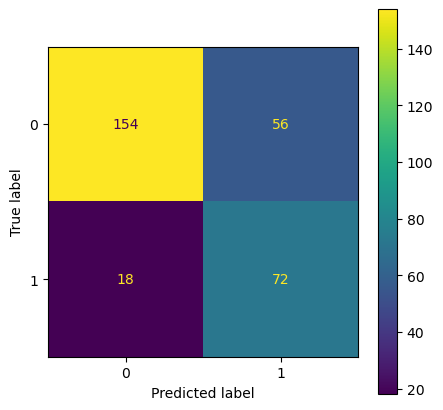

In [19]:
# confusion matrix
plt.rcParams['figure.figsize']=(5, 5) 
cm = confusion_matrix(y_test, y_hat_tuned)  
cm_display = ConfusionMatrixDisplay(cm, display_labels=search.classes_)

cm_display.plot()
plt.show() 

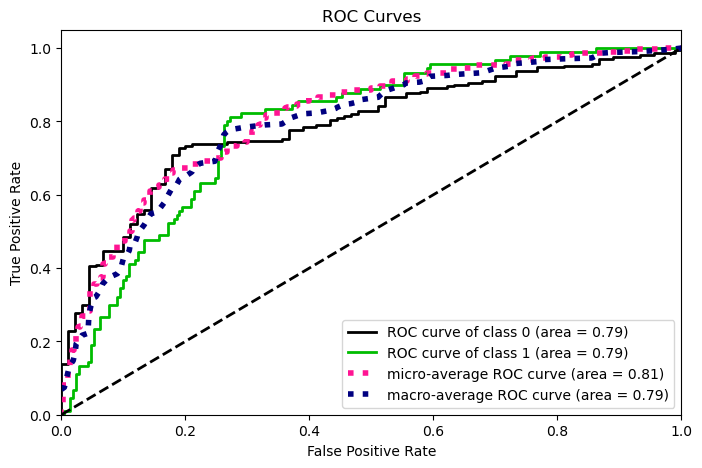

In [20]:
# roc curve
plt.rcParams['figure.figsize']=(8, 5) 
plot_roc(y_test, y_prob)
plt.show()

## Conclusion:

After tuning the positive threshold of Logistic regression, I get better performance than tuned Adaboost across all three metrics of 75% accuracy and 80% recall on the validation dataset. It is also significant to note that I am using a larger proportion of the data as the validation dataset. 

This model is clearly superior for predicting Probability of Default than AdaBoost.

In [21]:
credit = pd.read_csv('credit.csv')
credit_new = credit.iloc[x_test.index,].copy()
credit_new['POD'] = y_prob[:,1]
credit_new.to_csv('data/data_with_pod.csv', index=False)